# <ins>APPRENTISSAGE DES IMAGES AVEC VGG16</ins>

## <ins>CHARGEMENT DES LIBRAIRIES</ins>

In [1]:
import numpy as np
import pandas as pd
import json

from glob import glob
import pathlib
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import h5py
import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-03 14:46:20.631388: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 14:46:20.668212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <ins>CHARGEMENT DE NOTRE DATASET TRAIN</ins>

In [2]:
X_train = pd.read_csv('train_df.csv', index_col=[0])
X_train.prdtypecode = X_train.prdtypecode.astype(str)
X_test = pd.read_csv('train_df.csv', index_col=[0])
X_test.prdtypecode = X_test.prdtypecode.astype(str)

display(X_train.head())
display(X_test.head())

,prdtypecode,filepath,produit_clean
20801,10,./images/train/image_1296257106_product_412830...,music journal notebook white paper edition
34711,2705,./images/train/image_1113907088_product_278513...,paris plus belle vacances liliane après opérat...
46725,1280,./images/train/image_890867971_product_1370941...,doudou lapin patapouf kaloo peluche boule bleu...
14558,1280,./images/train/image_1282020176_product_405387...,buyiesky®peluche hiver bottes neige american g...
3039,1160,./images/train/image_900656095_product_1462627...,foil premium collecteur âmes magic mtg fleau mint


,prdtypecode,filepath,produit_clean
20801,10,./images/train/image_1296257106_product_412830...,music journal notebook white paper edition
34711,2705,./images/train/image_1113907088_product_278513...,paris plus belle vacances liliane après opérat...
46725,1280,./images/train/image_890867971_product_1370941...,doudou lapin patapouf kaloo peluche boule bleu...
14558,1280,./images/train/image_1282020176_product_405387...,buyiesky®peluche hiver bottes neige american g...
3039,1160,./images/train/image_900656095_product_1462627...,foil premium collecteur âmes magic mtg fleau mint


## <ins>GENERATEUR DE DONNEES</ins>

Les transformations appliquées sur notre image seront :

- une fonction de prétraitement du modèle VGG16 : preprocess_input.
- une rotation aléatoire sur une plage de 10 degrés.
- une translation verticale et horizontale sur une plage de 10% des dimensions de l'images.
- un agrandissement sur une plage 10% de l'image.
- un retournement aléatoire horizontal de l'image.

In [3]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split = 0.2, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.1, horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

## <ins>CREATION D UN DATASET TENSORFLOW A PARTIR DES CHEMINS ET DES ETIQUETTES</ins>

## <ins>ITERATEUR</ins>

Cette méthode permettra de charger les images, de générér pour chaque iteration des lots de données (batchs) transformé par le générateur d'images.

In [4]:
BATCH_SIZE = 32


train_generator = train_data_generator.flow_from_dataframe(
    dataframe=X_train,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
    )

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe=X_train,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'validation'
    )

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=X_test,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= 1,
    class_mode= 'categorical',
    shuffle = False, 
    )

Found 45684 validated image filenames belonging to 27 classes.
Found 11420 validated image filenames belonging to 27 classes.
Found 57104 validated image filenames belonging to 27 classes.


##  <ins>CREATION DE NOTRE MODELE VGG AVEC 7 COUCHES SUPPLEMENTAIRES</ins>

In [5]:
from keras.applications.vgg16 import VGG16

n_class = 27

base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

# blocage du backbone:
for layer in base_model.layers:
   layer.trainable = False  

inputs = keras.Input(shape= (224,224,3))

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True,axis=1)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True, axis=1)(x)
outputs = tf.keras.layers.Dense(n_class, activation="softmax")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.summary()

2024-05-03 14:48:35.729607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 14:48:35.734828: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 14:48:35.734859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 14:48:35.737142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 14:48:35.737173: I external/local_xla/xla/stream_executor

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,784,795 (60.21 MB)

 Trainable params: 1,067,035 (4.07 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

In [9]:
model.compile(loss=keras.losses.CategoricalFocalCrossentropy(), optimizer = 'adam', metrics=['accuracy'])

## <ins>DERNIERES PREPARATION - CALLBACKS</ins>

In [10]:

save_best_models_path = "/datas/sauvegarde_modele/vgg16_freeze/vgg16_callback.weights.h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
                    
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_best_models_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
                     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,  mode='min')

# Entrainement

callbacks = [model_checkpoint, reduce_lr, earlystopping]

## <ins>FIT DU MODELE VGG16</ins>

In [11]:
# entrainement avec la méthode .fit()
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714747850.768838     572 service.cc:145] XLA service 0x7f258401be20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714747850.768884     572 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-03 14:50:50.813004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-03 14:50:51.045737: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:171

   1/1428 ━━━━━━━━━━━━━━━━━━━━ 7:40:07 19s/step - accuracy: 0.0625 - loss: 1.0045

I0000 00:00:1714747866.319924     572 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 207/1428 ━━━━━━━━━━━━━━━━━━━━ 6:19 311ms/step - accuracy: 0.2877 - loss: 0.6274

I0000 00:00:1714747932.456709     708 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2314', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714747932.539200     707 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2314', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1714747932.553493     716 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2314', 40 bytes spill stores, 40 bytes spill loads



1428/1428 ━━━━━━━━━━━━━━━━━━━━ 615s 417ms/step - accuracy: 0.3820 - loss: 0.4707 - val_accuracy: 0.5021 - val_loss: 0.3214 - learning_rate: 0.0010
Epoch 2/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 542s 378ms/step - accuracy: 0.4927 - loss: 0.3188 - val_accuracy: 0.5398 - val_loss: 0.2917 - learning_rate: 0.0010
Epoch 3/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 536s 373ms/step - accuracy: 0.5128 - loss: 0.3000 - val_accuracy: 0.5454 - val_loss: 0.2859 - learning_rate: 0.0010
Epoch 4/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 543s 378ms/step - accuracy: 0.5352 - loss: 0.2813 - val_accuracy: 0.5388 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 5/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 537s 374ms/step - accuracy: 0.5427 - loss: 0.2706 - val_accuracy: 0.5468 - val_loss: 0.2835 - learning_rate: 0.0010
Epoch 6/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 540s 377ms/step - accuracy: 0.5499 - loss: 0.2611 - val_accuracy: 0.5602 - val_loss: 0.2739 - learning_rate: 0.0010
Epoch 7/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 548s 382ms/step - acc

In [14]:
# Chemin pour enregistrer le modèle
model_path = '/datas/sauvegarde_modele/vgg16_freeze/vgg16_freeze.keras'

# Save the cloned model
model.save(model_path)

In [ ]:
# Chargement du modèle EfficientNetB1
model_img = tf.keras.models.load_model("sauvegarde_modele/efficientnetV2/efficientnetV2.keras")
model_img.compile(loss = keras.losses.CategoricalFocalCrossentropy(), optimizer = keras.optimizers.Adam(), metrics=['accuracy'])

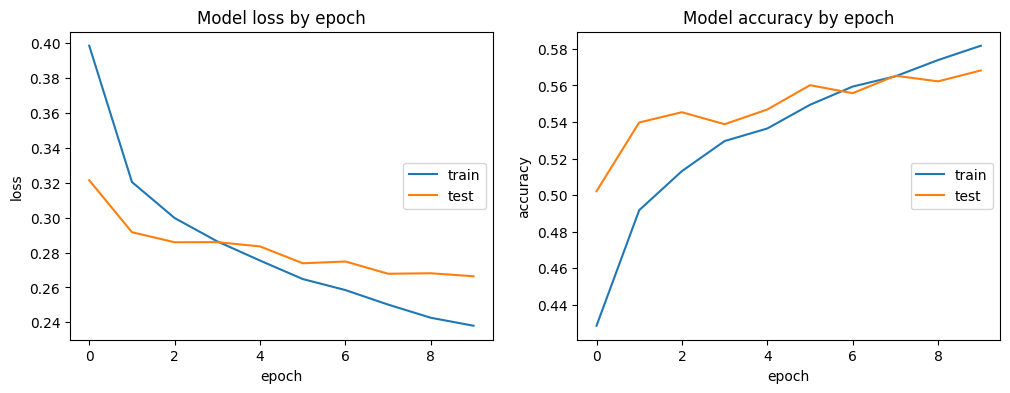

In [15]:

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [16]:
# Probabilités renvoyées par le modèle
y_prob = model.predict(test_generator, batch_size=1)

# Prédiction de la classe
y_pred = tf.argmax(y_prob, axis=-1).numpy()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57104/57104 ━━━━━━━━━━━━━━━━━━━━ 565s 10ms/step


In [17]:
# Vraies étiquettes
y_test = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [18]:
# Classification report
from sklearn.metrics import classification_report, accuracy_score, f1_score

print(classification_report(y_test, y_pred, target_names = class_labels))


              precision    recall  f1-score   support

          10       0.54      0.36      0.43      1970
        1140       0.65      0.62      0.63      1553
        1160       0.87      0.88      0.87      2173
        1180       0.63      0.41      0.49       494
        1280       0.56      0.43      0.49      3400
        1281       0.39      0.32      0.35      1432
        1300       0.65      0.75      0.70      3391
        1301       0.73      0.63      0.68       509
        1302       0.51      0.58      0.54      1670
        1320       0.66      0.46      0.54      2176
        1560       0.68      0.56      0.61      3664
        1920       0.83      0.79      0.81      3051
        1940       0.70      0.69      0.69       527
        2060       0.50      0.65      0.57      3585
        2220       0.71      0.44      0.54       610
        2280       0.64      0.74      0.68      3016
        2403       0.62      0.63      0.62      2905
        2462       0.68    

In [19]:
# Calcul accuracy
print ("ACCURACY DU MODELE : ", accuracy_score(y_test, y_pred), end = "\n\n")
# Calcul f1_score
print("F1_SCORE_WEIGHTED : ", f1_score(y_test, y_pred, average = 'weighted'), end = "\n\n")

ACCURACY DU MODELE :  0.6388519193051275

F1_SCORE_WEIGHTED :  0.6323855199557097



## <ins>DE-FREEZ DES 8 DERNIERES COUCHES DE NOTRE MODELE VGG16</ins>

Lors de l'apprentissage précédent, nous avons "freezé" les poids du modèle VGG16 CNN puisqu'ils étaient proches des poids optimaux et que les poids du classifieur étaient initialisés de manière aléatoire.

Nous allons maintenant rechercher une meilleure solution en reprenant notre modèle appris précédément et "dé-freezer" les couches les unes après les autres du vgg16 . De plus, nous utilisons une learning rate plus faible pour ajuster plus finement les paramètres.

In [21]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

lr = 0.0001
optimizer = Adam(learning_rate=lr)

# compile avec modification de l'optimizer
model.compile(loss=keras.losses.CategoricalFocalCrossentropy(), optimizer = 'adam', metrics=['accuracy'])

save_best_models_path = "/datas/sauvegarde_modele/vgg16_unfreeze/vgg16_unfreeze.weights.h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
                    
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_best_models_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
                     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,  mode='min')

# Entrainement

callbacks = [model_checkpoint, reduce_lr, earlystopping]

# entrainement avec la méthode .fit()
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/10


I0000 00:00:1714804374.898727    1553 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2326', 84 bytes spill stores, 84 bytes spill loads



 677/1428 ━━━━━━━━━━━━━━━━━━━━ 3:49 305ms/step - accuracy: 0.1237 - loss: 0.7216

I0000 00:00:1714804590.970357    1623 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2326', 96 bytes spill stores, 96 bytes spill loads



1428/1428 ━━━━━━━━━━━━━━━━━━━━ 572s 391ms/step - accuracy: 0.1326 - loss: 0.6878 - val_accuracy: 0.1828 - val_loss: 0.5836 - learning_rate: 0.0010
Epoch 2/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 554s 386ms/step - accuracy: 0.1946 - loss: 0.5698 - val_accuracy: 0.2583 - val_loss: 0.5054 - learning_rate: 0.0010
Epoch 3/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 558s 389ms/step - accuracy: 0.2896 - loss: 0.4872 - val_accuracy: 0.3216 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 4/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 558s 389ms/step - accuracy: 0.3397 - loss: 0.4460 - val_accuracy: 0.3528 - val_loss: 0.4469 - learning_rate: 0.0010
Epoch 5/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 566s 394ms/step - accuracy: 0.3767 - loss: 0.4159 - val_accuracy: 0.3880 - val_loss: 0.4131 - learning_rate: 0.0010
Epoch 6/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 563s 393ms/step - accuracy: 0.4120 - loss: 0.3904 - val_accuracy: 0.4101 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 7/10
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 562s 392ms/step - acc

## <ins>SAUVEGARDE DE NOTRE MODELLE</ins>

In [22]:
# Chemin pour enregistrer le modèle
model_path = '/datas/sauvegarde_modele/vgg16_unfreeze/vgg16_unfreeze.keras'

# Enregistrement du modèle
model.save(model_path)

## <ins>AFFICHAGE DE LA COURBE FONCTION COUT ET PRECISION EN FONCTION DE L EPOCH</ins>

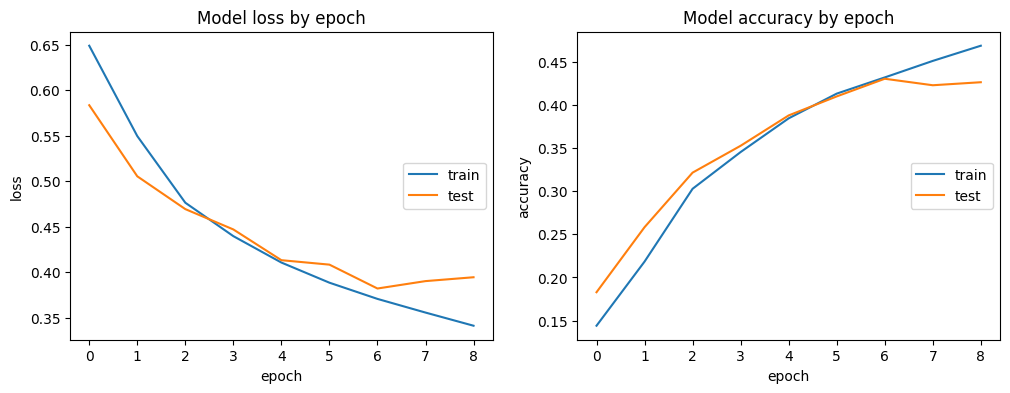

In [23]:

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

#### SCORES

In [24]:
# Probabilités renvoyées par le modèle
y_prob = model.predict(test_generator, batch_size=1)

# Prédiction de la classe
y_pred = tf.argmax(y_prob, axis=-1).numpy()

57104/57104 ━━━━━━━━━━━━━━━━━━━━ 592s 10ms/step


In [25]:
# Vraies étiquettes
y_test = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [26]:
# Classification report
from sklearn.metrics import classification_report, accuracy_score, f1_score

print(classification_report(y_test, y_pred, target_names = class_labels))


              precision    recall  f1-score   support

          10       0.38      0.46      0.42      1970
        1140       0.35      0.39      0.37      1553
        1160       0.81      0.77      0.79      2173
        1180       0.01      0.00      0.00       494
        1280       0.23      0.52      0.32      3400
        1281       0.27      0.13      0.18      1432
        1300       0.36      0.61      0.45      3391
        1301       0.06      0.01      0.01       509
        1302       0.07      0.01      0.01      1670
        1320       0.27      0.21      0.23      2176
        1560       0.49      0.43      0.46      3664
        1920       0.62      0.69      0.65      3051
        1940       0.36      0.10      0.16       527
        2060       0.41      0.20      0.26      3585
        2220       0.00      0.00      0.00       610
        2280       0.59      0.73      0.65      3016
        2403       0.50      0.48      0.49      2905
        2462       0.35    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Calcul accuracy
print ("ACCURACY DU MODELE : ", accuracy_score(y_test, y_pred), end = "\n\n")
# Calcul f1_score
print("F1_SCORE_WEIGHTED : ", f1_score(y_test, y_pred, average = 'weighted'), end = "\n\n")

ACCURACY DU MODELE :  0.45702577752871953

F1_SCORE_WEIGHTED :  0.4249902846215123

